## Traffic Sign Recognition System Using Deep Learning
#### CSCI 5625: Computer Vision
#### Authors: Preetham Bingi and Shwejan Shashank Keerthi

The goal of this project is to develop an accurate traffic sign recognition system using the GTSRB (German Traffic Sign Recognition Benchmark) dataset. This project will utilize deep learning models for classifying various traffic signs in real-time, providing a foundation for applications in autonomous driving and driver assistance systems.

##### Dataset Overview

The GTSRB dataset is a large, multi-class, single-image classification dataset with:
* More than 40 traffic sign classes representing real-world categories.
* Over 50,000 images with varying conditions such as lighting, occlusions, and angles, making the dataset lifelike and challenging.

### I. Exploratory data analysis (EDA)

In [1]:
## Importing libraries

# Basic libraries
import os
import math
import numpy as np
import pandas as pd
from collections import Counter
from PIL import Image
import cv2

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for model building and image preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Scikit-learn for data splitting and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

/Users/preethambingi/Documents/MS/Fall Semester 2024/CSCI 5625 - Computer Vision/CSCI 5625 - Project/CSProject/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Defining base path and paths to folders and CSV files
base_path = '/Users/preethambingi/Documents/MS/Fall Semester 2024/CSCI 5625 - Computer Vision/CSCI 5625 - Project/GTSRB'
meta_folder = os.path.join(base_path, 'Meta')
train_folder = os.path.join(base_path, 'Train')
test_folder = os.path.join(base_path, 'Test')
meta_csv = os.path.join(base_path, 'Meta.csv')
train_csv = os.path.join(base_path, 'Train.csv')
test_csv = os.path.join(base_path, 'Test.csv')

In [3]:
# Loading Train.csv to examine the distribution of classes and other details 
train_data = pd.read_csv(train_csv)
train_data.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png

In [4]:
# Dictionary for label names
label_names = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}

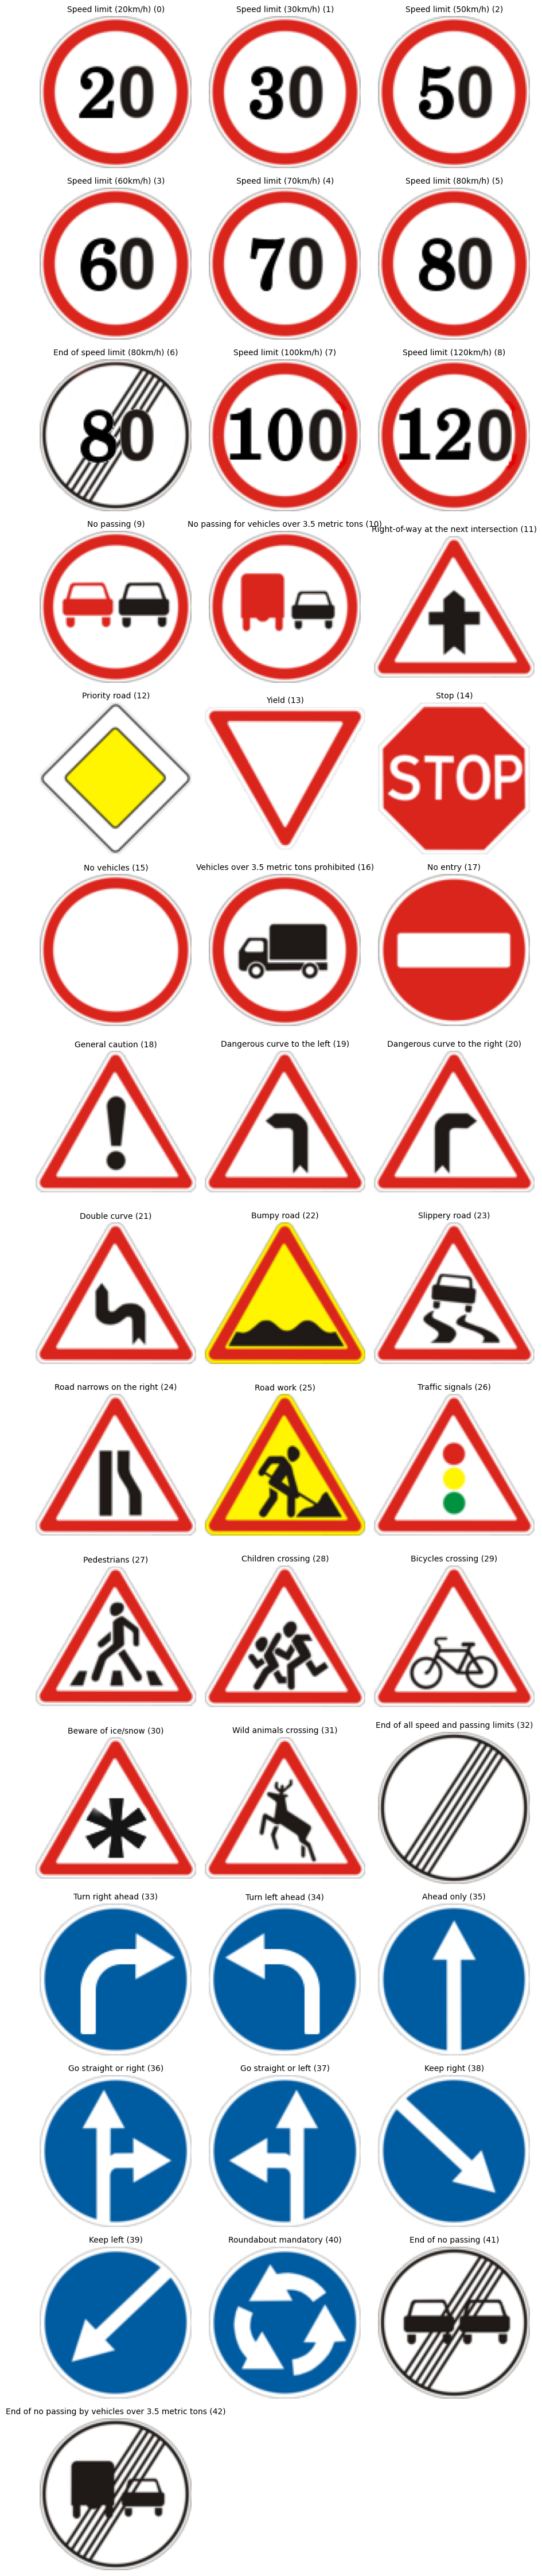

In [5]:
# Displaying sample images with labels from metadata
def display_images_from_meta(base_path, num_samples=43, images_per_row=5):
    image_files = [f for f in os.listdir(base_path) if f.endswith('.png')]
    
    df = pd.DataFrame({
        'Path': image_files,
        'ClassId': [int(os.path.splitext(f)[0]) for f in image_files]
    })
    
    df_sorted = df.sort_values(by='ClassId').head(num_samples)
    
    num_rows = math.ceil(num_samples / images_per_row)
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 3, num_rows * 3))
    axes = axes.flatten()
    
    for i, (index, row) in enumerate(df_sorted.iterrows()):
        img_path = os.path.join(base_path, row['Path'])
        
        img = Image.open(img_path)
        label_name = label_names.get(row['ClassId'], "Unknown")
        axes[i].imshow(img)
        axes[i].set_title(f"{label_name} ({row['ClassId']})", fontsize=10)
        axes[i].axis('off')
    
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

display_images_from_meta(meta_folder, num_samples=43, images_per_row=3)

/var/folders/z1/ghzx56593955fj08zf9rypxr0000gn/T/ipykernel_16847/4115532516.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


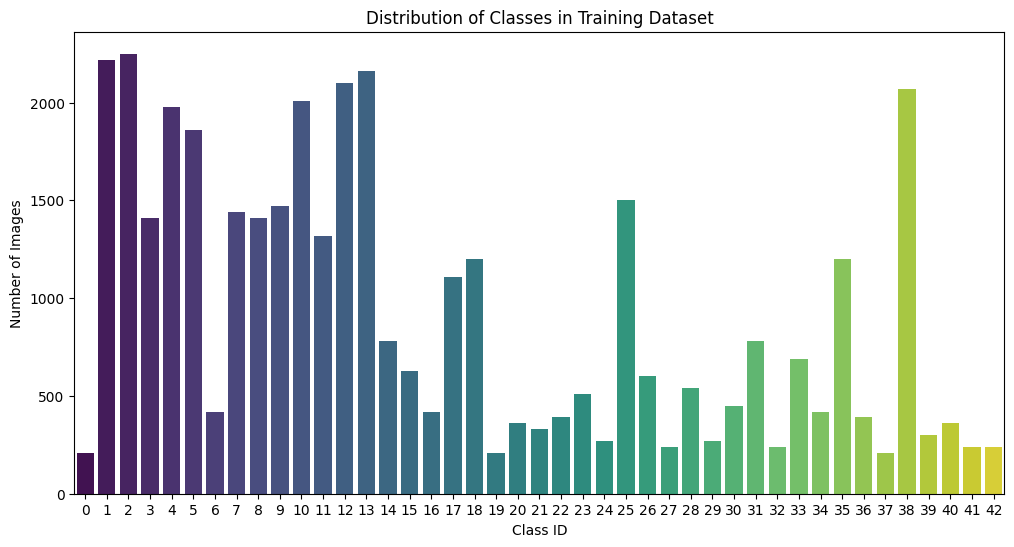

In [6]:
# Visualizing the distribution of images across different classes to check for class imbalance 

class_counts = train_data['ClassId'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Distribution of Classes in Training Dataset")
plt.show()

Interpretation: This plot helps in understanding if any classes are underrepresented or overrepresented, which may affect model performance.

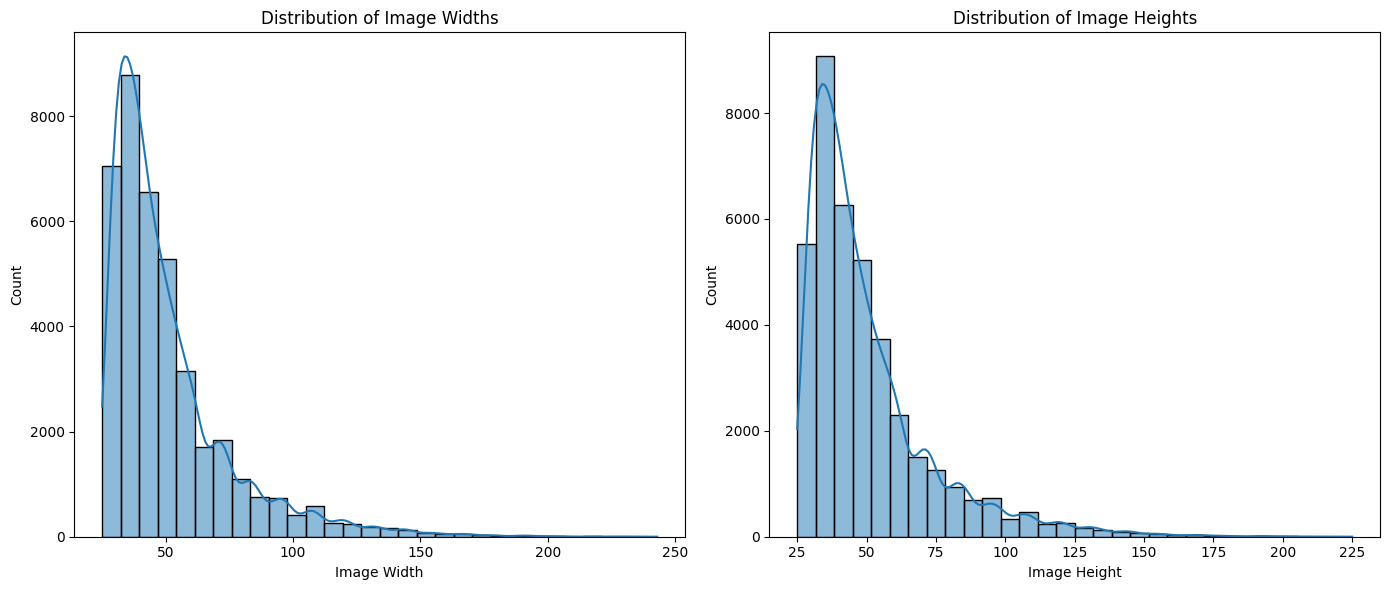

In [7]:
# Checking the size distribution of images, as variations in image size could impact preprocessing and model performance.

image_sizes = []

for path in train_data['Path']:
    img_path = os.path.join(base_path, path)
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

image_sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(image_sizes_df['Width'], bins=30, kde=True)
plt.xlabel("Image Width")
plt.title("Distribution of Image Widths")

plt.subplot(1, 2, 2)
sns.histplot(image_sizes_df['Height'], bins=30, kde=True)
plt.xlabel("Image Height")
plt.title("Distribution of Image Heights")

plt.tight_layout()
plt.show()

Interpretation: This analysis reveals if images have consistent dimensions. If there are significant variations, resizing might be necessary during preprocessing.

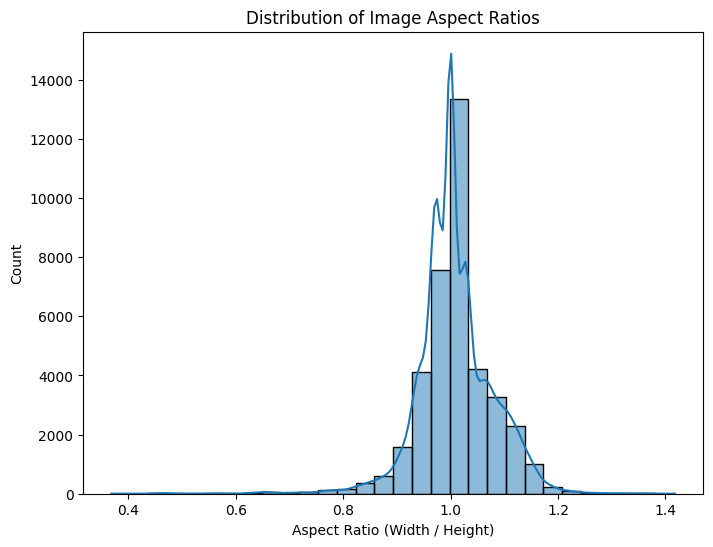

In [8]:
# Analyzing the aspect ratio (width/height) of images to check if they vary widely, which might indicate a need for careful resizing.

image_sizes_df['Aspect_Ratio'] = image_sizes_df['Width'] / image_sizes_df['Height']

plt.figure(figsize=(8, 6))
sns.histplot(image_sizes_df['Aspect_Ratio'], bins=30, kde=True)
plt.xlabel("Aspect Ratio (Width / Height)")
plt.title("Distribution of Image Aspect Ratios")
plt.show()

Interpretation: Ideally, images have a consistent aspect ratio. A wide range in aspect ratios might require additional preprocessing to avoid image distortion when resizing.


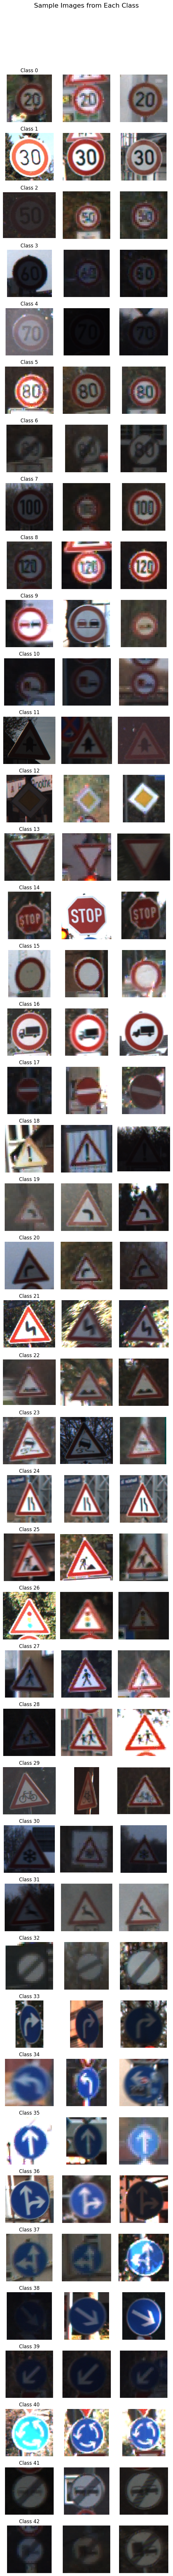

In [9]:
# Displaying a few sample images from each class to visually inspect variations within and across classes.

def plot_samples_per_class(data_df, base_dir, samples_per_class=3):
    fig, axes = plt.subplots(nrows=43, ncols=samples_per_class, figsize=(samples_per_class * 2, 43 * 2))
    fig.suptitle("Sample Images from Each Class", y=1.02, fontsize=16)
    
    for class_id in sorted(data_df['ClassId'].unique()):
        class_images = data_df[data_df['ClassId'] == class_id].sample(samples_per_class, replace=True)
        
        for i, (idx, row) in enumerate(class_images.iterrows()):
            img_path = os.path.join(base_dir, row['Path'])
            with Image.open(img_path) as img:
                axes[class_id, i].imshow(img)
                axes[class_id, i].axis('off')
                if i == 0:
                    axes[class_id, i].set_title(f"Class {class_id}")
                    
    plt.tight_layout()
    plt.show()

plot_samples_per_class(train_data, base_path, samples_per_class=3)

Interpretation: This provides a visual understanding of intra-class and inter-class variability. You can identify whether some classes look visually similar, which could lead to misclassifications.

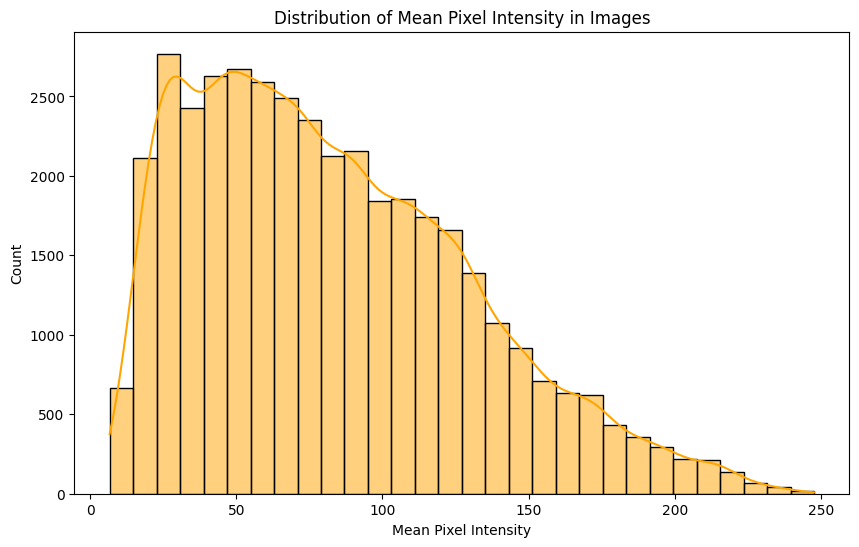

In [10]:
# Checking if there are notable differences in brightness or contrast across classes.

mean_intensities = []
for path in train_data['Path']:
    img_path = os.path.join(base_path, path)
    with Image.open(img_path) as img:
        img_array = np.array(img)
        mean_intensities.append(img_array.mean())

train_data['Mean_Intensity'] = mean_intensities

plt.figure(figsize=(10, 6))
sns.histplot(train_data['Mean_Intensity'], bins=30, kde=True, color='orange')
plt.xlabel("Mean Pixel Intensity")
plt.title("Distribution of Mean Pixel Intensity in Images")
plt.show()

Interpretation: This analysis reveals if images differ in brightness. For example, classes with significantly lower or higher intensities may require brightness adjustment to ensure model performance.

### II. Data Preprocessing

In [11]:
# Loading the data

def load_data_from_csv(csv_path, base_dir, img_size=(30, 30)):
    
    data = []
    labels = []
    
    df = pd.read_csv(csv_path)
    
    for index, row in df.iterrows():
        img_path = os.path.join(base_dir, row['Path'])
        label = row['ClassId']
        
        image = Image.open(img_path)
        image = image.resize(img_size)
        image_array = np.array(image)
        
        data.append(image_array)
        labels.append(label)
        
    X = np.array(data)
    y = np.array(labels)
    
    return X, y

# Loading training data
X_train, y_train = load_data_from_csv(train_csv, base_path)
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

# Loading testing data
X_test, y_test = load_data_from_csv(test_csv, base_path)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (39209, 30, 30, 3)
Training labels shape: (39209,)
Testing data shape: (12630, 30, 30, 3)
Testing labels shape: (12630,)


In [12]:
# Normalizing images
X_train, X_test = X_train / 255.0, X_test / 255.0

In [13]:
# Splitting training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
# Using data augmentation to improve generalization
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
)
datagen.fit(X_train)

### III. Model Development

In [15]:
# Defining the CNN model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')  # Adjust the number of classes if needed
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/preethambingi/Documents/MS/Fall Semester 2024/CSCI 5625 - Computer Vision/CSCI 5625 - Project/CSProject/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

### IV. Training

In [16]:
# Training the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=30,
    validation_data=(X_val, y_val)
)

Epoch 1/30


/Users/preethambingi/Documents/MS/Fall Semester 2024/CSCI 5625 - Computer Vision/CSCI 5625 - Project/CSProject/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1146 - loss: 3.3129 - val_accuracy: 0.4753 - val_loss: 1.6690
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4381 - loss: 1.7869 - val_accuracy: 0.7209 - val_loss: 0.8607
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6222 - loss: 1.1429 - val_accuracy: 0.8671 - val_loss: 0.4489
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7338 - loss: 0.8082 - val_accuracy: 0.9339 - val_loss: 0.2669
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7941 - loss: 0.6265 - val_accuracy: 0.9543 - val_loss: 0.1936
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8316 - loss: 0.5204 - val_accuracy: 0.9700 - val_loss: 0.1291
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8599 - loss: 0.4331 - val_accuracy: 0.9828 - val_loss: 0.1066
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8732 - loss: 0.3859 - val_accuracy: 0.98

### V. Evaluation

In [17]:
# Evaluating the model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9630 - loss: 0.1286
Test Accuracy: 0.9615201950073242


In [18]:
# Generating predictions for the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [19]:
# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9615
Precision: 0.9637
Recall: 0.9615
F1 Score: 0.9615


In [20]:
# Printing classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(43)]))


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.93      1.00      0.96       720
           2       0.96      0.97      0.96       750
           3       1.00      0.93      0.96       450
           4       1.00      0.95      0.97       660
           5       0.94      0.94      0.94       630
           6       0.98      0.97      0.98       150
           7       1.00      0.92      0.96       450
           8       0.92      0.99      0.95       450
           9       0.97      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.94      0.93      0.94       420
          12       1.00      0.96      0.98       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.93      0.99      0.96       210
          16       0.99      1.00      0.99       150
  

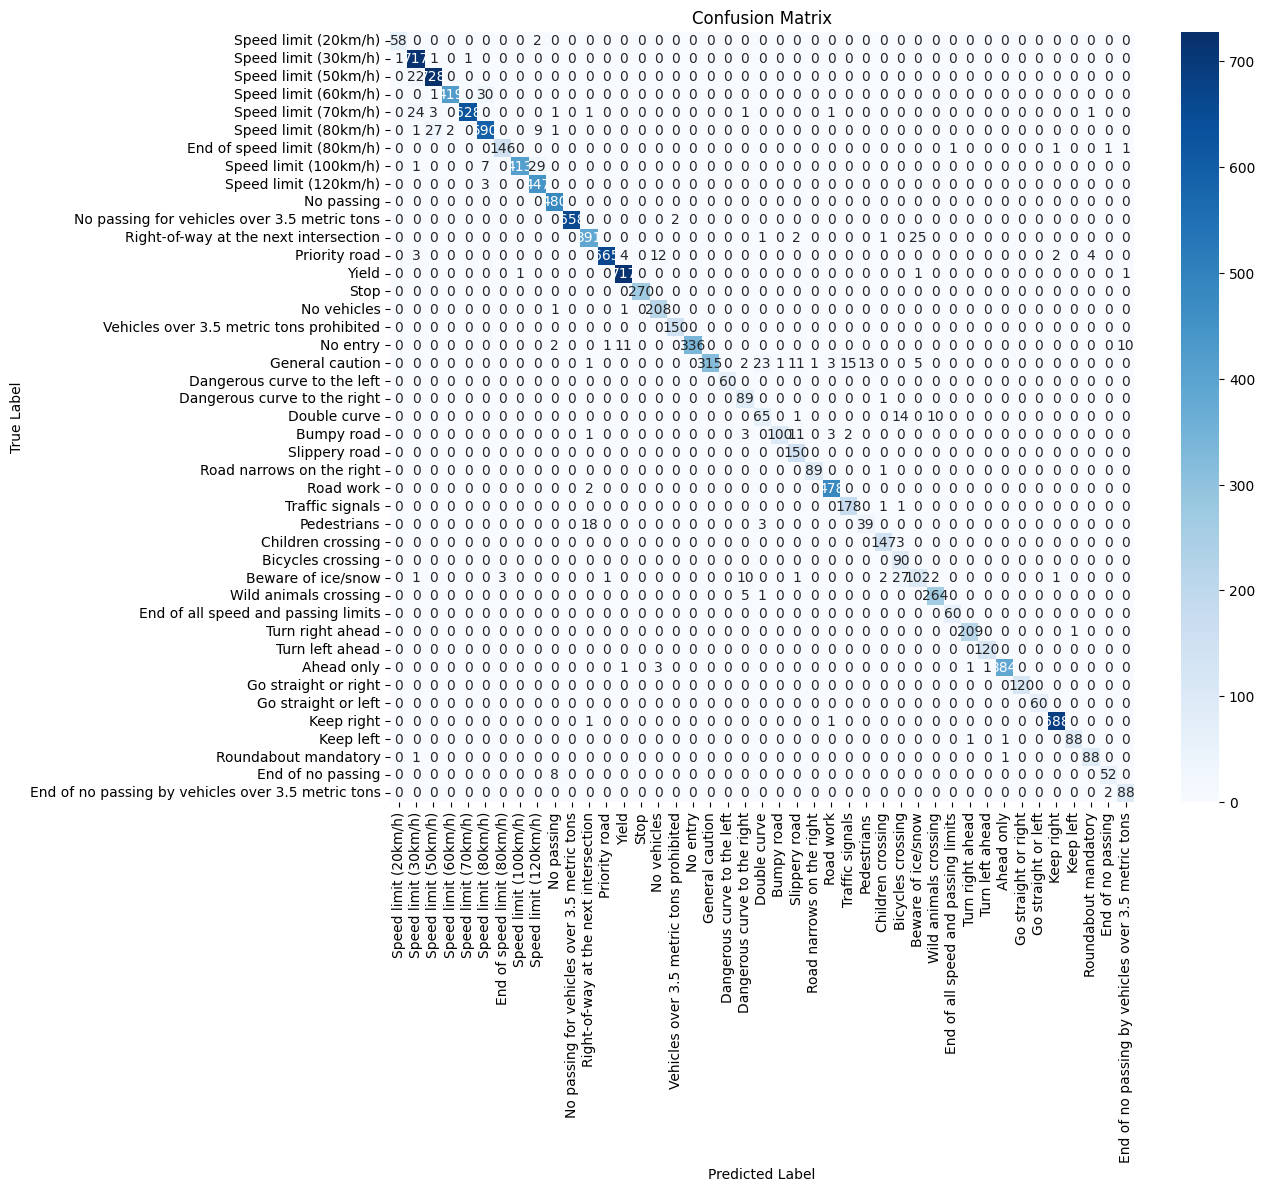

In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# Identifying Well-Performing and Poorly-Performing Classes
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for class_id, accuracy in enumerate(class_accuracy):
    print(f"Class {class_id} ({label_names[class_id]}): Accuracy = {accuracy:.2f}")
    
threshold = 0.90  # Threshold for "good" performance
well_performing_classes = [label_names[i] for i in np.where(class_accuracy > threshold)[0]]
poorly_performing_classes = [label_names[i] for i in np.where(class_accuracy < threshold)[0]]

print("Well-performing classes:", well_performing_classes)
print("Poorly-performing classes:", poorly_performing_classes)

Class 0 (Speed limit (20km/h)): Accuracy = 0.97
Class 1 (Speed limit (30km/h)): Accuracy = 1.00
Class 2 (Speed limit (50km/h)): Accuracy = 0.97
Class 3 (Speed limit (60km/h)): Accuracy = 0.93
Class 4 (Speed limit (70km/h)): Accuracy = 0.95
Class 5 (Speed limit (80km/h)): Accuracy = 0.94
Class 6 (End of speed limit (80km/h)): Accuracy = 0.97
Class 7 (Speed limit (100km/h)): Accuracy = 0.92
Class 8 (Speed limit (120km/h)): Accuracy = 0.99
Class 9 (No passing): Accuracy = 1.00
Class 10 (No passing for vehicles over 3.5 metric tons): Accuracy = 1.00
Class 11 (Right-of-way at the next intersection): Accuracy = 0.93
Class 12 (Priority road): Accuracy = 0.96
Class 13 (Yield): Accuracy = 1.00
Class 14 (Stop): Accuracy = 1.00
Class 15 (No vehicles): Accuracy = 0.99
Class 16 (Vehicles over 3.5 metric tons prohibited): Accuracy = 1.00
Class 17 (No entry): Accuracy = 0.93
Class 18 (General caution): Accuracy = 0.81
Class 19 (Dangerous curve to the left): Accuracy = 1.00
Class 20 (Dangerous curve t

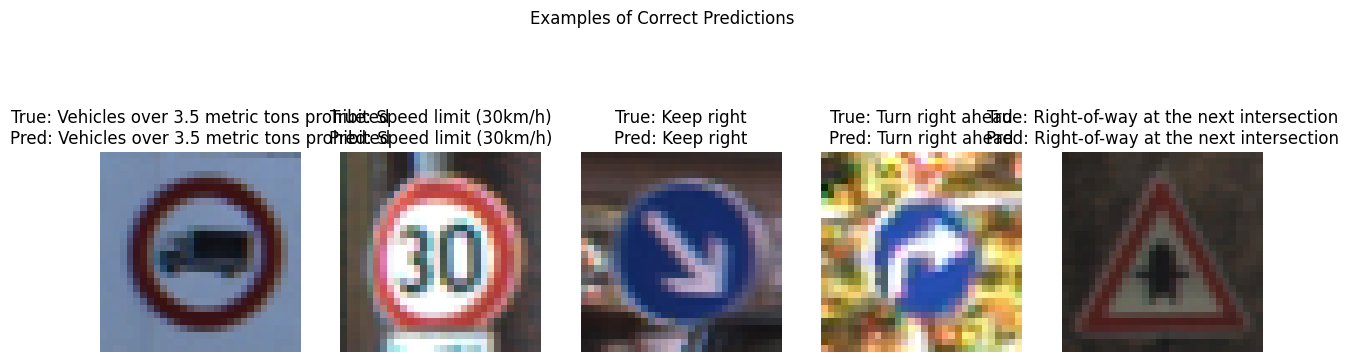

In [23]:
# Visualizing examples of correct predictions

correct_indices = np.where(y_pred == y_test)[0]
num_examples = 5 

plt.figure(figsize=(15, 5))
for i, idx in enumerate(correct_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {label_names[y_test[idx]]}\nPred: {label_names[y_pred[idx]]}")
    plt.axis('off')
plt.suptitle("Examples of Correct Predictions")
plt.show()

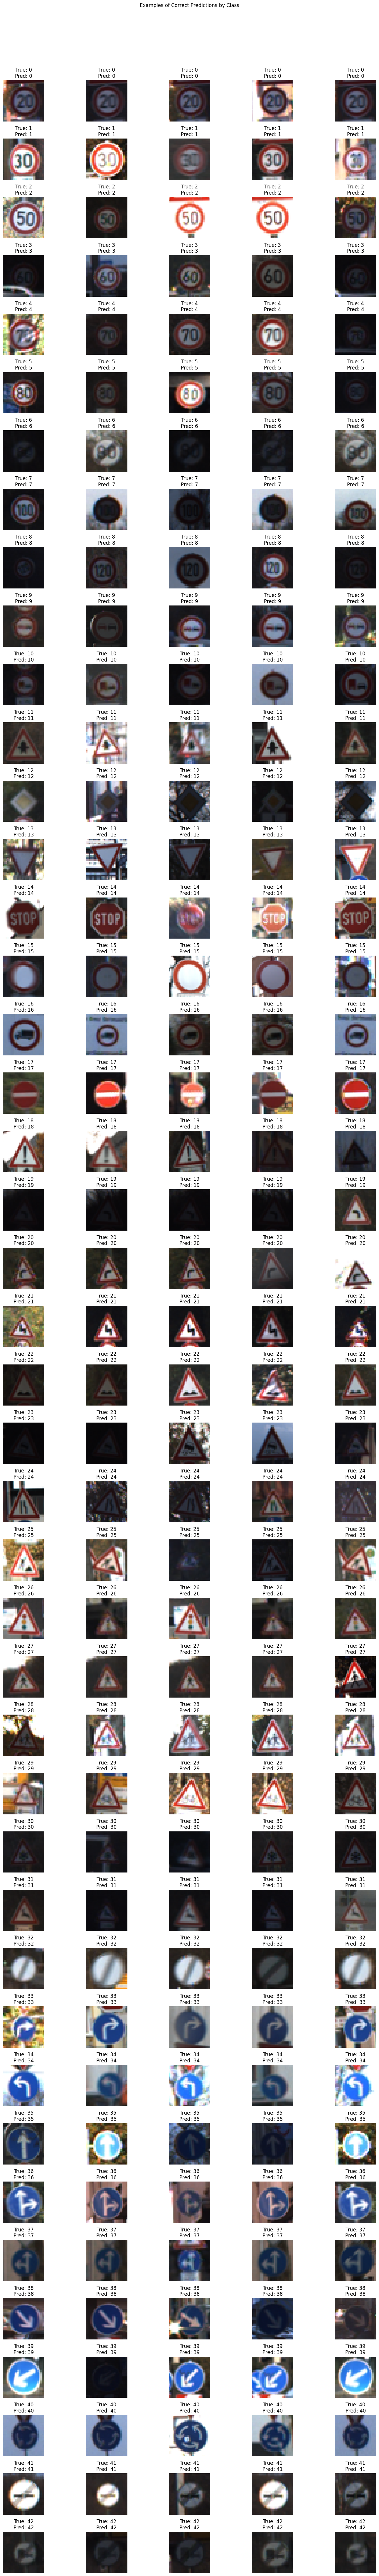

In [24]:
# Displaying sample correct predictions for each class

num_classes = 43
num_examples_per_class = 5

plt.figure(figsize=(15, num_classes * 2))

for class_id in range(num_classes):
    correct_indices = np.where((y_pred == y_test) & (y_test == class_id))[0]
    
    for i, idx in enumerate(correct_indices[:num_examples_per_class]):
        plt_idx = class_id * num_examples_per_class + i + 1
        plt.subplot(num_classes, num_examples_per_class, plt_idx)
        
        plt.imshow(X_test[idx])
        plt.title(f"True: {class_id}\nPred: {y_pred[idx]}")
        plt.axis('off')

plt.suptitle("Examples of Correct Predictions by Class", y=1.02)
plt.tight_layout()
plt.show()

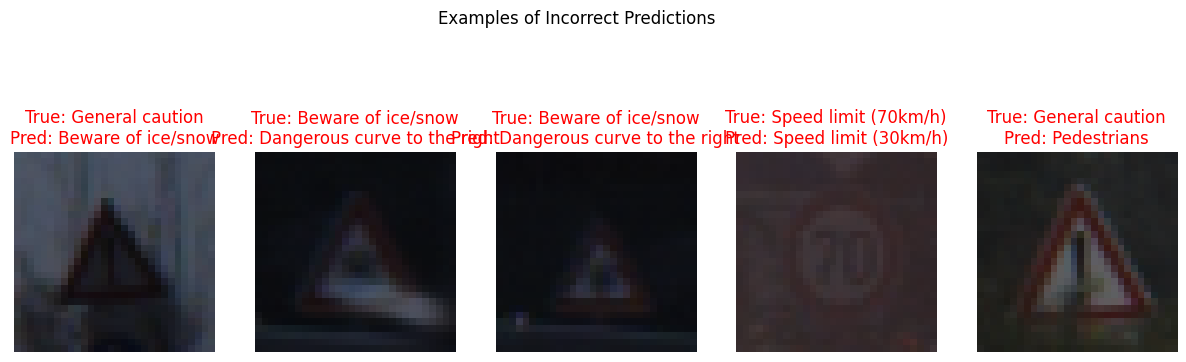

In [25]:
# Visualizing examples of incorrect predictions
incorrect_indices = np.where(y_pred != y_test)[0]

plt.figure(figsize=(15, 5))
for i, idx in enumerate(incorrect_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {label_names[y_test[idx]]}\nPred: {label_names[y_pred[idx]]}", color='red')
    plt.axis('off')
plt.suptitle("Examples of Incorrect Predictions")
plt.show()

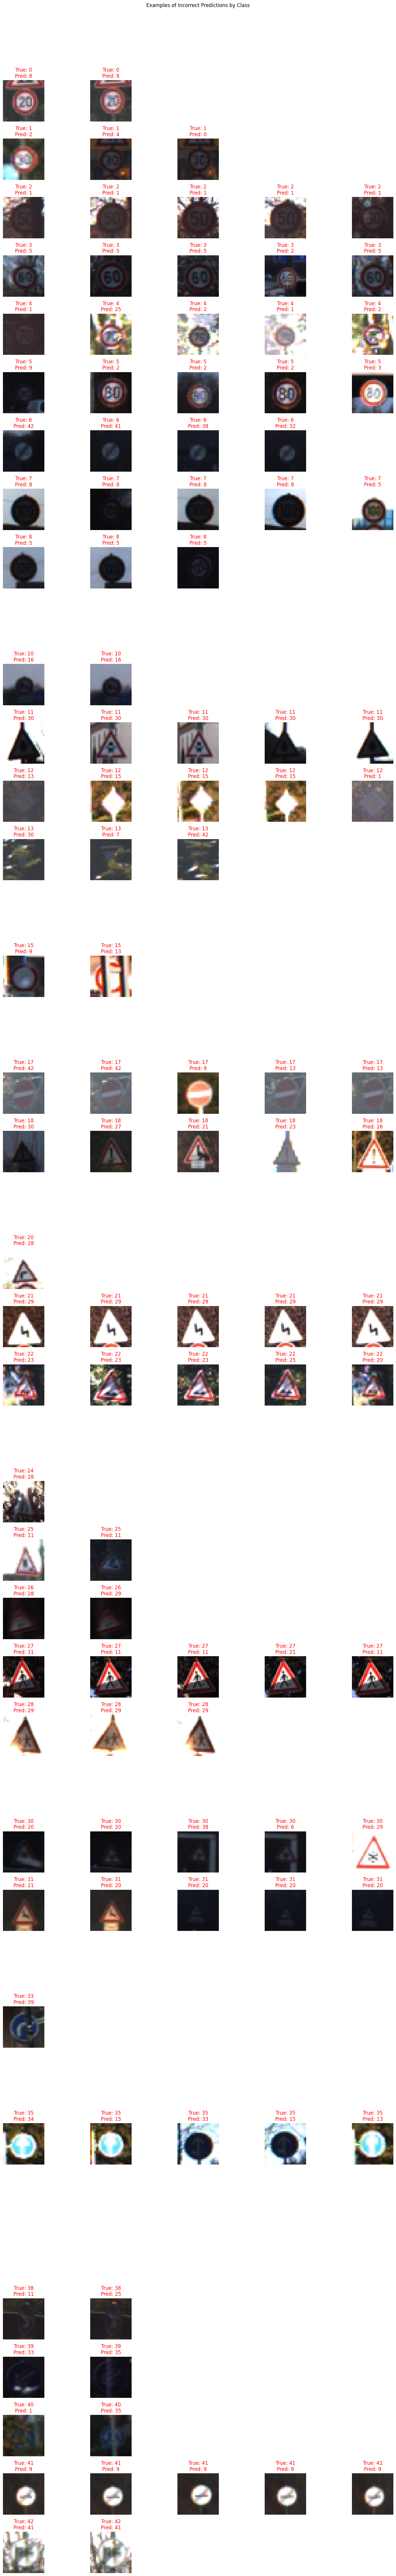

In [26]:
# Displaying sample incorrect predictions for each class

num_examples_per_class = 5

plt.figure(figsize=(15, num_classes * 2))

for class_id in range(num_classes):
    incorrect_indices = np.where((y_pred != y_test) & (y_test == class_id))[0]
    
    for i, idx in enumerate(incorrect_indices[:num_examples_per_class]):
        plt_idx = class_id * num_examples_per_class + i + 1
        plt.subplot(num_classes, num_examples_per_class, plt_idx)
        
        plt.imshow(X_test[idx])
        plt.title(f"True: {class_id}\nPred: {y_pred[idx]}", color='red')
        plt.axis('off')

plt.suptitle("Examples of Incorrect Predictions by Class", y=1.02)
plt.tight_layout()
plt.show()

In [27]:
## Analyzing patterns in misclassifications

# Identifying pairs of classes with the highest misclassification rate
conf_matrix_no_diag = conf_matrix.copy()
np.fill_diagonal(conf_matrix_no_diag, 0)

most_confused_pairs = np.unravel_index(np.argmax(conf_matrix_no_diag), conf_matrix_no_diag.shape)
print(f"Most confused classes: {label_names[most_confused_pairs[0]]} and {label_names[most_confused_pairs[1]]}")

Most confused classes: Speed limit (60km/h) and Speed limit (80km/h)


In [28]:
# Saving the model
model.save("traffic_sign_model.h5")